In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd gdrive/MyDrive/VQA_torch
%ls

/content/gdrive/MyDrive/VQA_torch
Annotations/       data_clevr/         Questions_Test_abstract_v002.zip
chk_simple/        external/           README.md
chk_simple_clevr/  Images/             runs/
coatt/             model_best.pth.tar  scene_img_abstract_v002_test2015.zip
data/              Questions/          tb_/


In [3]:
!pip install tensorboardX

     |████████████████████████████████| 124 kB 5.3 MB/s 


In [4]:
import numpy as np
from six.moves import cPickle as pickle
from torch.utils.data import DataLoader

from coatt.simple_baseline_net import SimpleBaselineNet
from coatt.experiment_runner_base import ExperimentRunnerBase
from coatt.vqa_dataset import VqaDataset

import os
import operator
import numpy as np

from six.moves import cPickle as pickle
from collections import defaultdict
from external.vqa.vqa import VQA

In [5]:
with open('./data/q2i.pkl', 'rb') as f:
    q2i = pickle.load(f)
with open('./data/a2i.pkl', 'rb') as f:
    a2i = pickle.load(f)
with open('./data/i2a.pkl', 'rb') as f:
    i2a = pickle.load(f)
with open('./data/a2i_count.pkl', 'rb') as f:
    a2i_count = pickle.load(f)

In [6]:
model = SimpleBaselineNet(len(q2i), 1000).float()

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [7]:
import torch

model.load_state_dict(torch.load('./model_best.pth.tar')['state_dict'])
model.eval()

SimpleBaselineNet(
  (gnet): GoogLeNet(
    (conv1): BasicConv2d(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): BasicConv2d(
      (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv3): BasicConv2d(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (inception3a): Inception(
      (branch1): BasicConv2d(
        (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        

In [9]:
va_img_names = np.load('./data/va_img_names.npy', encoding='latin1').tolist()
va_img_ids = np.load('./data/va_img_ids.npy', encoding='latin1').tolist()
va_ques_ids = np.load('./data/va_ques_ids.npy', encoding='latin1').tolist()

test_image_dir = './Images/val2015'
test_question_path = './Questions/OpenEnded_abstract_v002_val2015_questions.json'
test_annotation_path = './Annotations/abstract_v002_val2015_annotations.json'

batch_size = 1
num_data_loader_workers = 10

val_dataset = VqaDataset(image_dir=test_image_dir, collate=True,
                         question_json_file_path=test_question_path,
                         annotation_json_file_path=test_annotation_path,
                         image_filename_pattern="abstract_v002_val2015_{}.png",
                         q2i=q2i, a2i=a2i, i2a=i2a, a2i_count=a2i_count,
                         img_names=va_img_names, img_ids=va_img_ids,
                         ques_ids=va_ques_ids, method="simple",
                         dataset_type="validation")

val_dataset_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_data_loader_workers)


simple
Img_prefix:  abstract_v002_val2015_
loading VQA annotations and questions into memory...
0:00:00.559388
creating index...
index created!


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [10]:
wrong_ids = []
wrong_ans = []
act_ans = []
ques_types = {}
accuracy = 0
DEVICE = 'cuda'
model.cuda()
for idx, (imgT, quesT, gT) in enumerate(val_dataset_loader):
    model.eval()
    imgT, quesT, gT = imgT.to(DEVICE), quesT.to(DEVICE), gT.to(DEVICE)
    gT = torch.squeeze(gT)
    pd_ans = model(imgT, quesT) # TODO
    model_answer = torch.argmax(pd_ans).item()
    if model_answer == gT:
       accuracy += 1.0
    else:
       wrong_ids.append(idx)
       wrong_ans.append(model_answer)
       act_ans.append(int(gT))
       img, ques, qa = val_dataset.getIdx(idx)
       if qa['question_type'] in ques_types.keys():
          ques_types[qa['question_type']] += 1
       else:
          ques_types[qa['question_type']] = 1
                    
                    
                  
accuracy = accuracy / 30000.0

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Question 73: What is the in the sky
Model answer:  sun
Actual answer:  bird


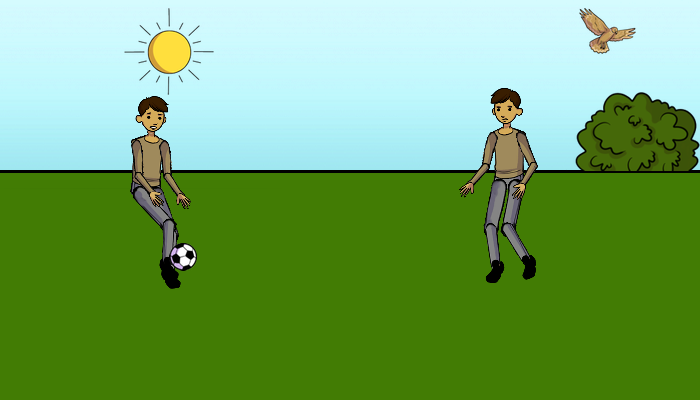

Possible answers: ['bird', 'sun and bird', 'sun and bird', 'sun', 'owl', 'sun', 'sun and owl', 'bird', 'bird', 'sunbird']


In [37]:
from PIL import Image
from numpy import random

rand_idx = np.random.choice(wrong_ids, 20)
count = 0

for idx in range(len(wrong_ids)):
    img, ques, answers = val_dataset.getIdx(wrong_ids[10785])
    print(f"Question {idx}:",ques)
    print("Model answer: ",i2a[wrong_ans[10785]])
    print("Actual answer: ",i2a[act_ans[10785]])
    #display(img)
    print('Possible answers:', [ans['answer'] for ans in answers['answers']])


In [44]:
sorted(ques_types.items(), key=operator.itemgetter(1), reverse=True)

[('how many', 1438),
 ('where is the', 865),
 ('what', 739),
 ('what is', 709),
 ('what color is the', 625),
 ('what is the', 512),
 ('is the', 443),
 ('what is on the', 401),
 ('who is', 287),
 ('none of the above', 262),
 ('are the', 235),
 ('what is in the', 235),
 ('what is the man', 217),
 ('what is the woman', 208),
 ('what is the boy', 204),
 ('what are the', 201),
 ('what kind of', 177),
 ('what is the girl', 173),
 ('which', 163),
 ('does the', 159),
 ('how many people are', 154),
 ('is there a', 153),
 ('is the woman', 142),
 ('how', 133),
 ('what is the dog', 129),
 ('why is the', 128),
 ('what type of', 127),
 ('what color are the', 110),
 ('where are the', 105),
 ('is the man', 101),
 ('is the dog', 101),
 ('what are they', 99),
 ('why', 98),
 ('what animal is', 95),
 ('what is the lady', 95),
 ('is the boy', 93),
 ('is there', 90),
 ('is it', 88),
 ('what is the cat', 87),
 ('is the girl', 87),
 ('are there', 87),
 ('how many trees are', 82),
 ('what is the little', 82),


In [7]:
import json

with open('abstract_v002_val2015_annotations.json') as f:
  ann = json.load(f)
overall_types = {}
for a in ann['annotations']:
  if a['question_type'] in overall_types.keys():
    overall_types[a['question_type']] += 1
  else:
    overall_types[a['question_type']] = 1



In [8]:
overall_types

{'are': 207,
 'are the': 893,
 'are the people': 134,
 'are there': 293,
 'are there any': 194,
 'are these': 116,
 'are they': 414,
 'can': 140,
 'did the': 149,
 'do': 182,
 'do the': 231,
 'does': 198,
 'does the': 689,
 'how': 222,
 'how many': 2933,
 'how many animals are': 97,
 'how many birds are': 89,
 'how many bushes': 88,
 'how many clouds are': 128,
 'how many people are': 274,
 'how many pictures': 103,
 'how many pillows': 120,
 'how many plants are': 85,
 'how many trees are': 135,
 'how many windows are': 121,
 'is': 182,
 'is anyone': 95,
 'is he': 134,
 'is it': 448,
 'is she': 207,
 'is that': 128,
 'is the': 1798,
 'is the baby': 198,
 'is the boy': 464,
 'is the cat': 237,
 'is the dog': 406,
 'is the girl': 437,
 'is the lady': 202,
 'is the little girl': 136,
 'is the man': 563,
 'is the old man': 70,
 'is the sun': 150,
 'is the tv': 101,
 'is the woman': 665,
 'is the young': 120,
 'is there': 370,
 'is there a': 729,
 'is this': 297,
 'is this a': 111,
 'none 

In [17]:
percents = {}
for ques, num in ques_types:
  percents[ques] = round(num / overall_types[ques], 2)
len(sorted(percents.items(), key=operator.itemgetter(1), reverse=True))

81

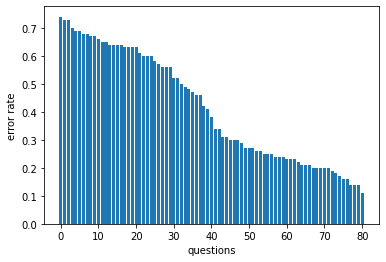

In [22]:
import matplotlib.pyplot as plt
y = []
for i in sorted(percents.items(), key=operator.itemgetter(1), reverse=True):
  y.append(i[1])

plt.bar(range(0,81), y)
plt.xlabel('questions')
plt.ylabel('error rate')
plt.show()